
# Intensity vs. Sdd (Both Total and Only Fetal) Plus Their Ratio
## Filter the Proper Raw Files

In [1]:
# Fetch the RAW data
from pathlib import Path
from glob import glob
import pandas as pd
import json
from inverse_modelling_tfo.data.generate_intensity import create_intensity_column, create_sdd_column
import matplotlib.pyplot as plt
import seaborn as sns

# Get all the raw files
raw_file_path = Path(r'/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil2')
raw_files = list(raw_file_path.glob("*.pkl"))  # RAW files are in pickle format
raw_files = [Path(file) for file in raw_files]

# Filter
chosen_wall_thicknesses = [8, 10, 12]
chosen_wavelength = 735
chosen_files = list(filter(lambda x: int(x.stem.split('_')[-1]) in chosen_wall_thicknesses, raw_files))
chosen_files = list(filter(lambda x: int(x.stem.split('_')[-3]) == chosen_wavelength, chosen_files))
config_files = [x.with_suffix('.json') for x in chosen_files]
print(chosen_files)

[PosixPath('/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil2/dan_iccps_pencil_wave_735_dermis_12.pkl'), PosixPath('/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil2/dan_iccps_pencil_wave_735_dermis_10.pkl'), PosixPath('/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil2/dan_iccps_pencil_wave_735_dermis_8.pkl')]


## Get the Raw DataFrame and the corresponding mu_a Values

In [2]:
# Get Optical Properties
from typing import List
from tfo_sim.model_creation.models import DanModel4LayerX
from tfo_sim.model_creation import SimulationParameters

all_sdd = []
raw_data_array: List[pd.DataFrame] = []
all_mu_a = []
all_ppath_columns = []

for file in chosen_files:
    raw_data = pd.read_pickle(file)    
    all_ppath_columns = list(filter(lambda x: 'ppath' in x, raw_data.columns))
    raw_data['Total ppath'] = raw_data[all_ppath_columns].sum(axis=1)
    raw_data = create_sdd_column(raw_data)
    all_sdd = raw_data['SDD'].unique()
    
    # mu_a    
    wavelength = float(file.name.split('_')[-3])
    sim_params = SimulationParameters(wavelength=wavelength)
    tissue_model = DanModel4LayerX(sim_params)
    props = tissue_model.get_optical_properties()
    mu_a = [layer['mua'] for layer in props]
    mu_a = mu_a[1:]     # Drop Air layer
    mu_map = {i + 1: mu_a[i] for i in range(len(mu_a))}     # 1-indexed
    all_mu_a.append(mu_a)
    
    # Intensity
    raw_data = create_intensity_column(raw_data, mu_map)
    raw_data_array.append(raw_data)

## Calculate Sensitivity

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt 
from inverse_modelling_tfo.data.intensity_normalization import config_based_normalization 

df = pd.DataFrame(columns=['Intensity', 'SDD', 'Fetal Depth', 'Wavelength', 'Intensity Type'])
sensitivity_df = pd.DataFrame(columns=['Sensitivity', 'SDD', 'Fetal Depth', 'Wavelength', 'Intensity'])
# Take Intensity Sum per SDD and put them onto a DataFrame
for raw_data, config in zip(raw_data_array, config_files):
    # Normalize the Intensity
    config_based_normalization(raw_data, config)
    wavelength = int(config.stem.split('_')[-3])
    wall_thickness = int(config.stem.split('_')[-1])
    total_intensity = raw_data.groupby('SDD')['Intensity'].sum()
    total_intensity = total_intensity.reset_index()
    ## Smooth the Intensity after SDD > 50
    total_intensity_before = total_intensity[total_intensity['SDD'] <= 50]
    total_intensity_after = total_intensity[total_intensity['SDD'] > 50].rolling(window=5, min_periods=1).mean()
    total_intensity = pd.concat([total_intensity_before, total_intensity_after])
    
    total_intensity['Fetal Depth'] = wall_thickness + 6
    total_intensity['Wavelength'] = wavelength
    total_intensity['Intensity Type'] = 'Total Intensity'
    df = pd.concat([df, total_intensity])
    
    # Fetal Sensitive Intensity
    fetal_sensitive_intensity = raw_data[raw_data['L4 ppath'] > 0].groupby('SDD')['Intensity'].sum()
    fetal_sensitive_intensity = fetal_sensitive_intensity.reset_index()
    ## Smooth the Intensity after SDD > 50
    fetal_sensitive_intensity_before = fetal_sensitive_intensity[fetal_sensitive_intensity['SDD'] <= 50]
    fetal_sensitive_intensity_after = fetal_sensitive_intensity[fetal_sensitive_intensity['SDD'] > 50].rolling(window=5, min_periods=1).mean()
    fetal_sensitive_intensity = pd.concat([fetal_sensitive_intensity_before, fetal_sensitive_intensity_after])
    fetal_sensitive_intensity['Fetal Depth'] = wall_thickness + 6
    fetal_sensitive_intensity['Wavelength'] = wavelength
    fetal_sensitive_intensity['Intensity Type'] = 'Fetal Sensitive Intensity'
    
    df = pd.concat([df, fetal_sensitive_intensity])
    
    # Sensitivity
    dS_dmu_f = (raw_data['L4 ppath'] * raw_data['Intensity']).groupby(raw_data['SDD']).mean()
    dS_dmu_m = (raw_data['L1 ppath'] * raw_data['Intensity']).groupby(raw_data['SDD']).mean()
    sensitivity = dS_dmu_f / (dS_dmu_f + dS_dmu_m)
    sensitivity.name = 'Sensitivity'
    sensitivity = sensitivity.reset_index()
    # Apply rolling window only after SDD > 50
    sensitivity_before = sensitivity[sensitivity['SDD'] <= 50]
    sensitivity_after = sensitivity[sensitivity['SDD'] > 50].rolling(window=5, min_periods=1).mean()
    sensitivity = pd.concat([sensitivity_before, sensitivity_after])
    
    
    sensitivity['Fetal Depth'] = wall_thickness + 6
    sensitivity['Wavelength'] = wavelength
    sensitivity['Intensity'] = total_intensity['Intensity']
    sensitivity_df = pd.concat([sensitivity_df, sensitivity])
    

## Plotting

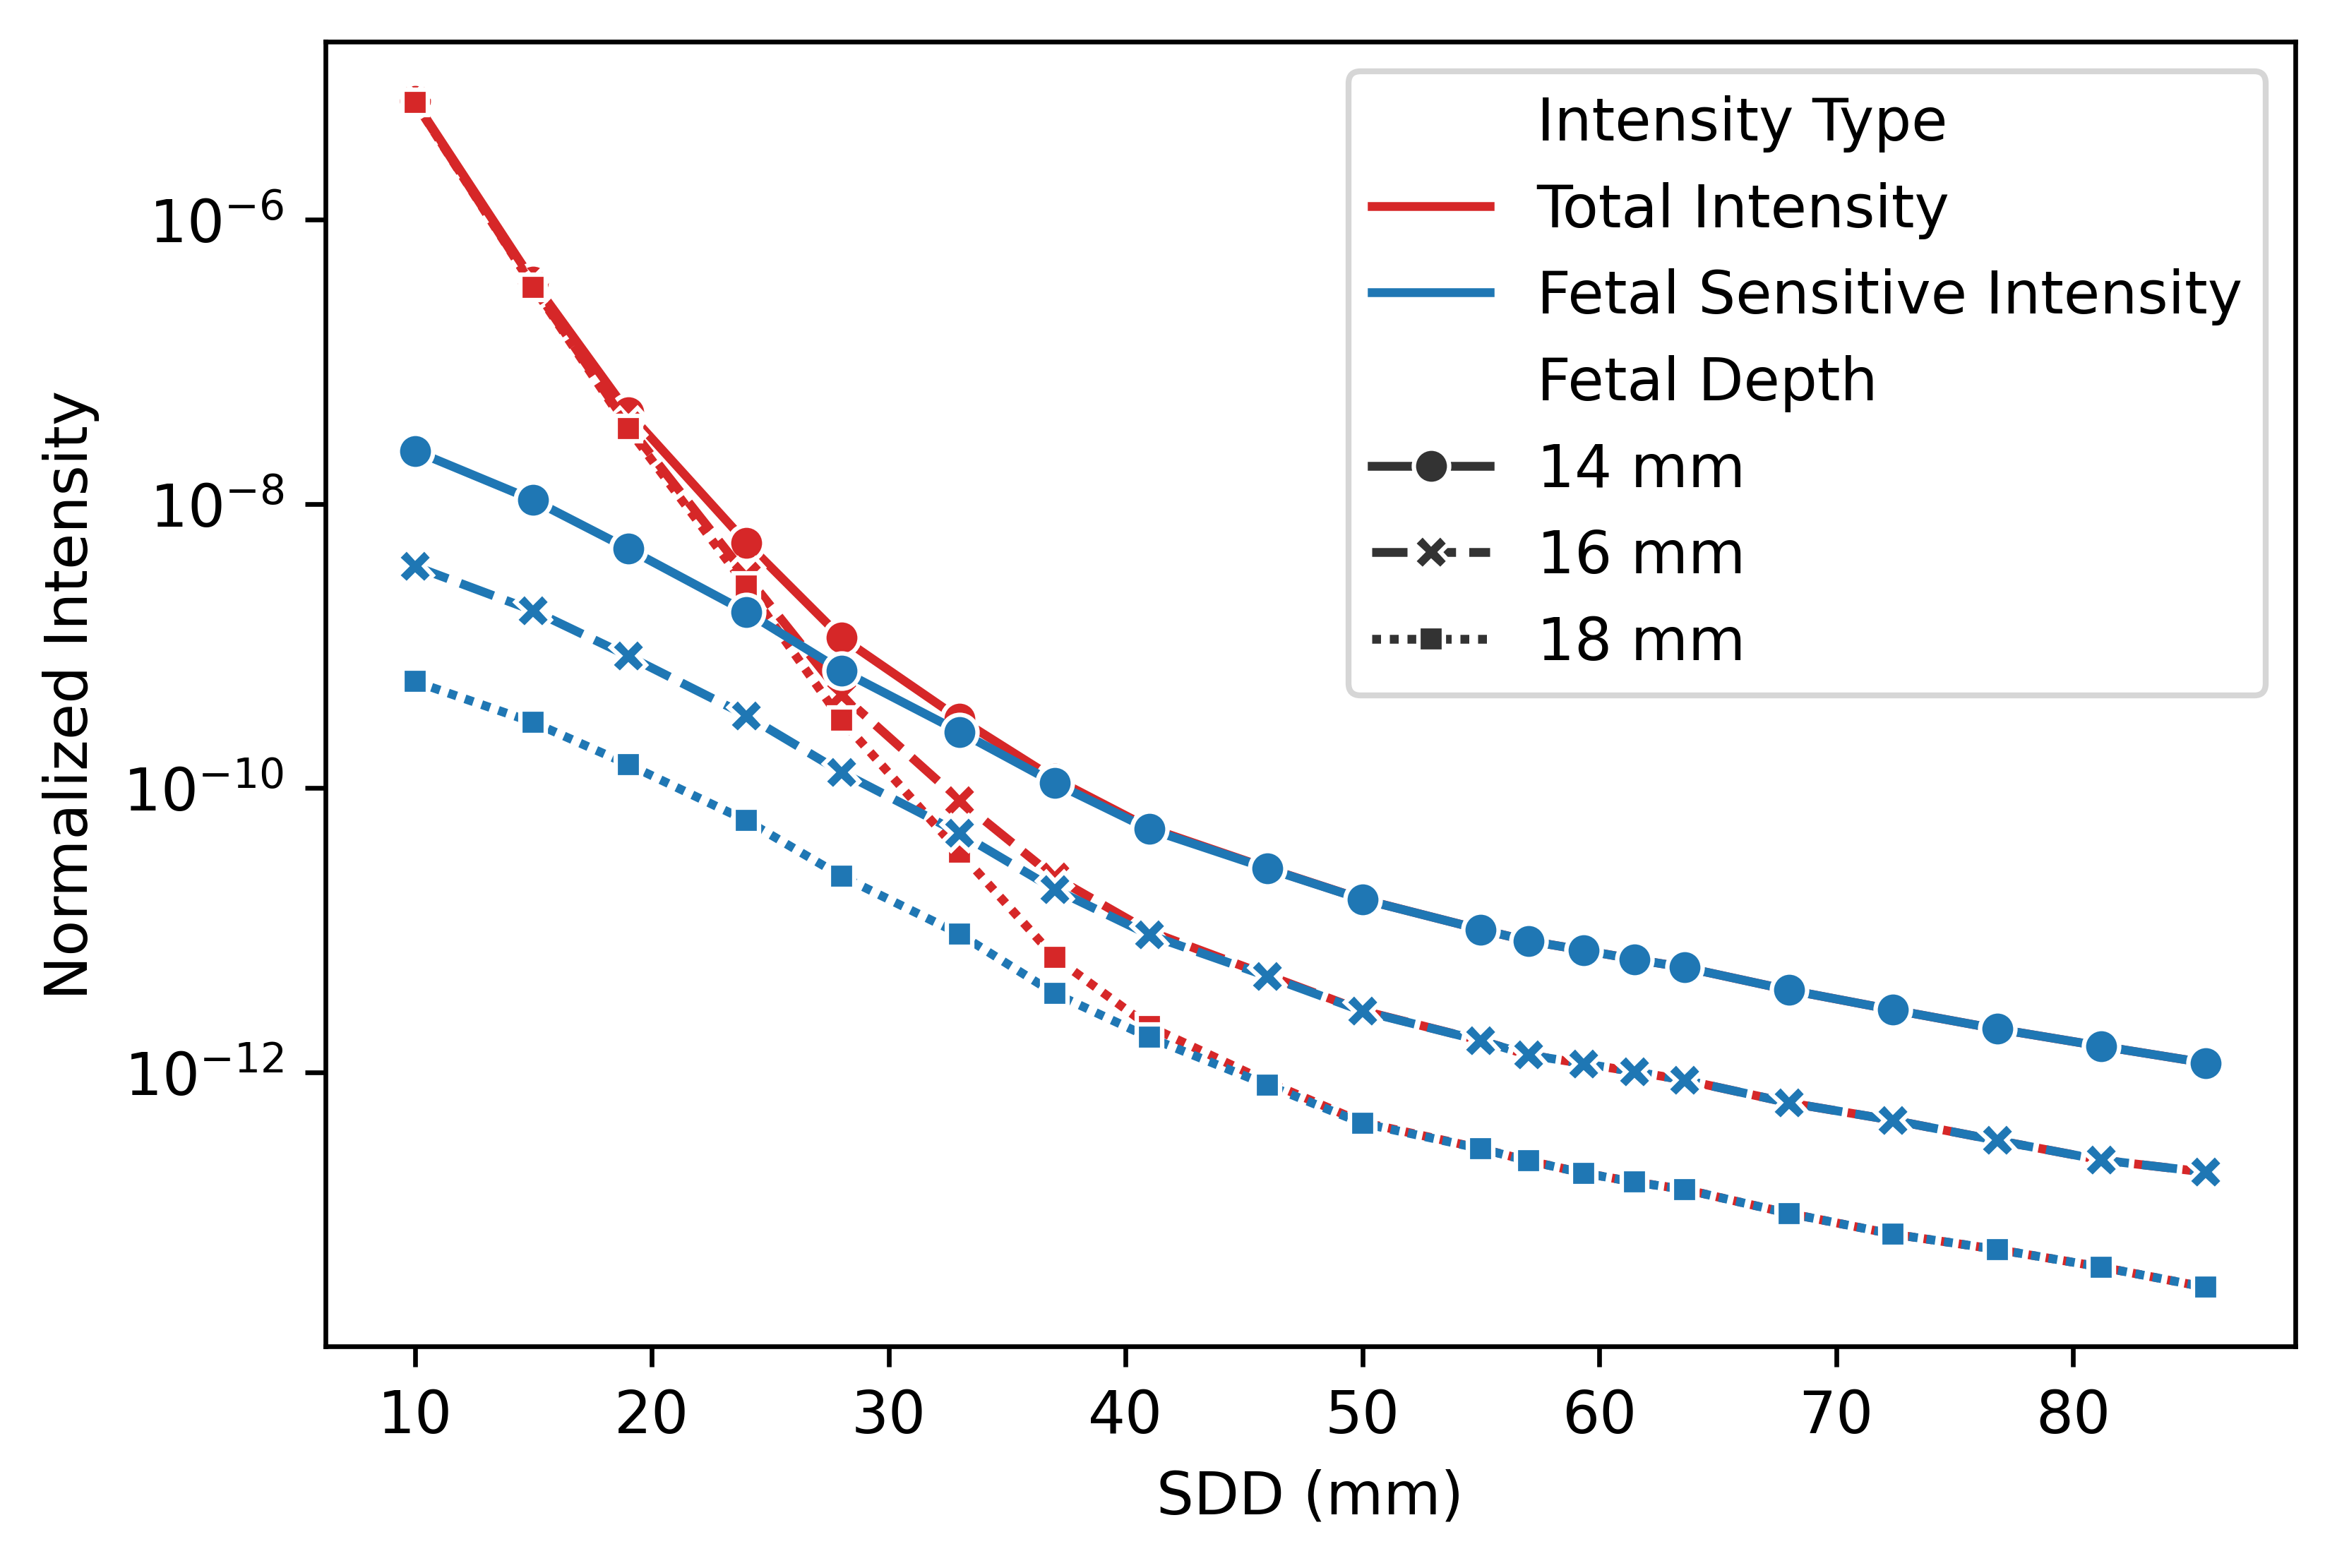

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting Specific Edits
df_to_plot = df.copy()
# Write mm at the end of Fetal Depth for all the values
df_to_plot['Fetal Depth'] = df_to_plot['Fetal Depth'].astype(str) + ' mm'

# Define the desired order of fetal depths
fetal_depth_order = sorted(df_to_plot['Fetal Depth'].unique(), key=lambda x: float(x.split()[0]))

# Define a custom color palette
custom_palette = {'Total Intensity': 'tab:red', 'Fetal Sensitive Intensity': 'tab:blue'}

# Plotting
plt.figure(figsize=(6, 4), dpi=600)
sns.lineplot(
    data=df_to_plot,
    x='SDD',
    y='Intensity',
    hue='Intensity Type',
    style='Fetal Depth',
    style_order=fetal_depth_order,
    markers=True,
    palette=custom_palette
)
plt.yscale('log')
plt.ylabel('Normalized Intensity')
plt.xlabel('SDD (mm)')
plt.show()

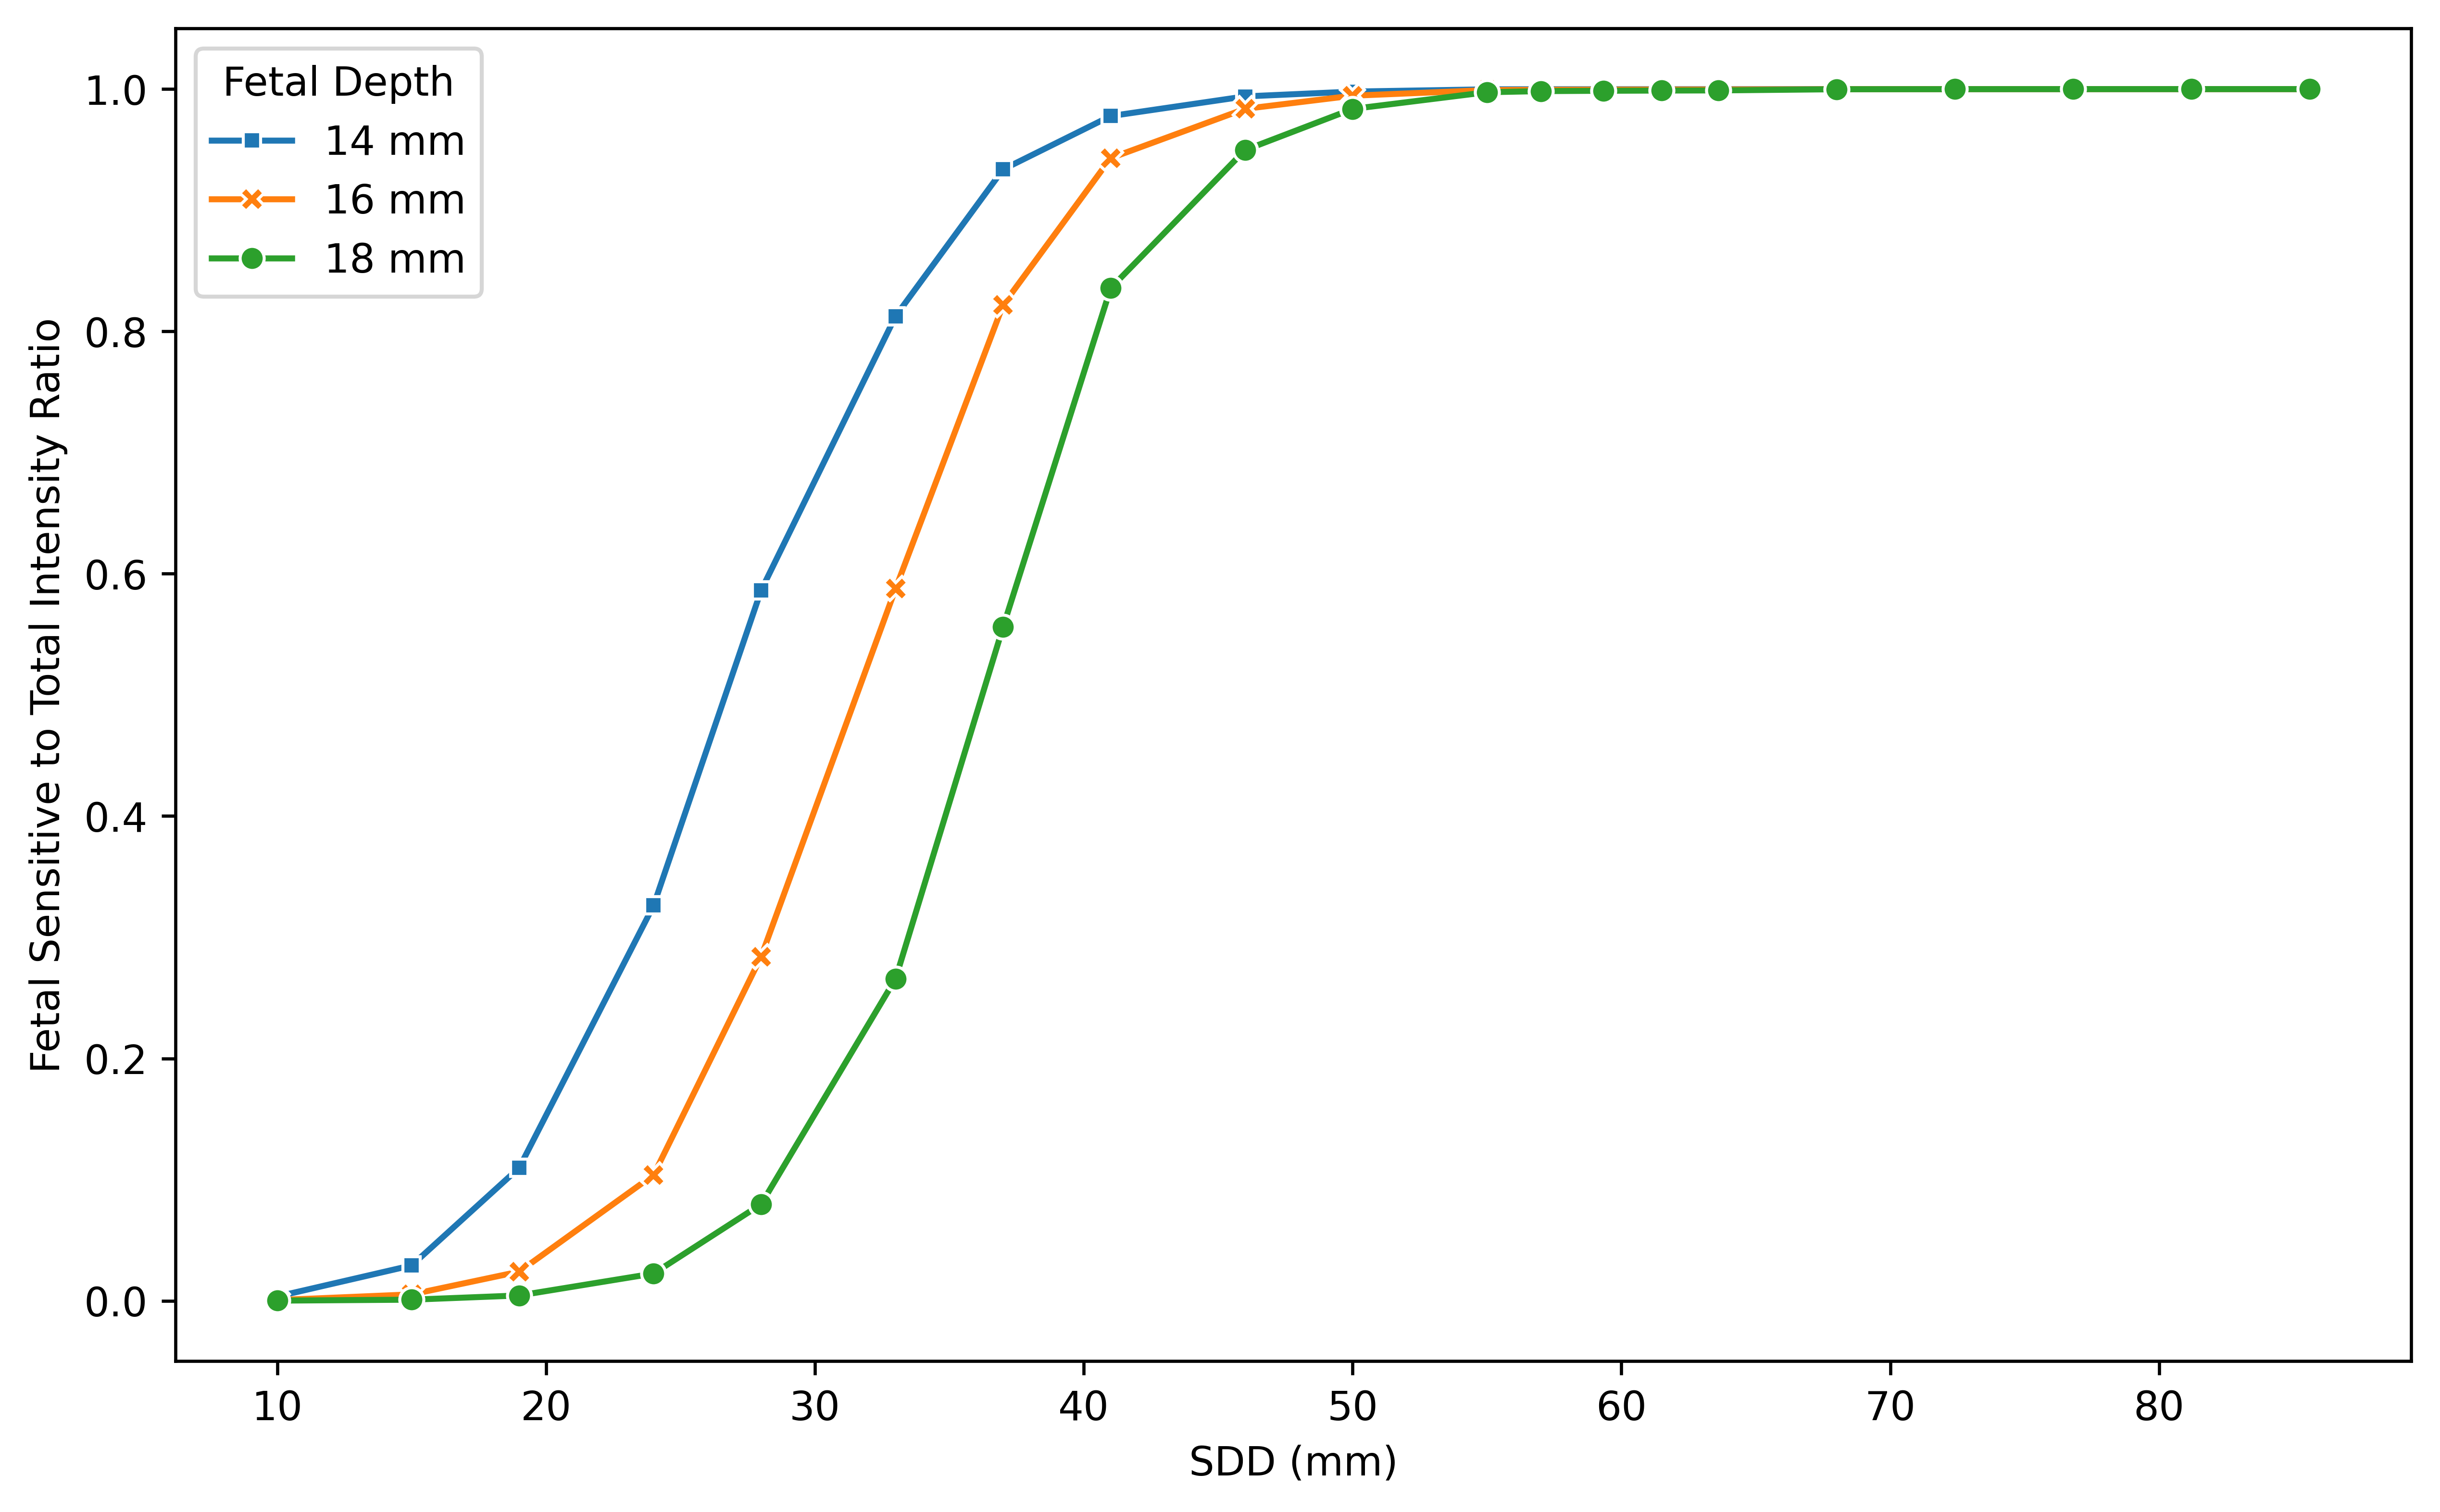

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get the Ratio of Fetal to Total Intensity
total_intensity = df_to_plot[df_to_plot["Intensity Type"] == "Total Intensity"]
fetal_intensity = df_to_plot[df_to_plot["Intensity Type"] == "Fetal Sensitive Intensity"]
merged = pd.merge(
    total_intensity, fetal_intensity, on=["SDD", "Fetal Depth", "Wavelength"], suffixes=("_Total", "_Fetal")
)
merged["Fetal Sensitive to Total Intensity Ratio"] = merged["Intensity_Fetal"] / merged["Intensity_Total"]

# Define the desired order of fetal depths
fetal_depth_order = sorted(merged["Fetal Depth"].unique(), key=lambda x: float(x.split()[0]))

plt.figure(figsize=(10, 6), dpi=600)
sns.lineplot(
    data=merged,
    x="SDD",
    y="Fetal Sensitive to Total Intensity Ratio",
    hue="Fetal Depth",
    hue_order=fetal_depth_order,
    style="Fetal Depth",
    markers=True,
    dashes=False,
)
plt.ylabel("Fetal Sensitive to Total Intensity Ratio")
plt.xlabel("SDD (mm)")
plt.show()

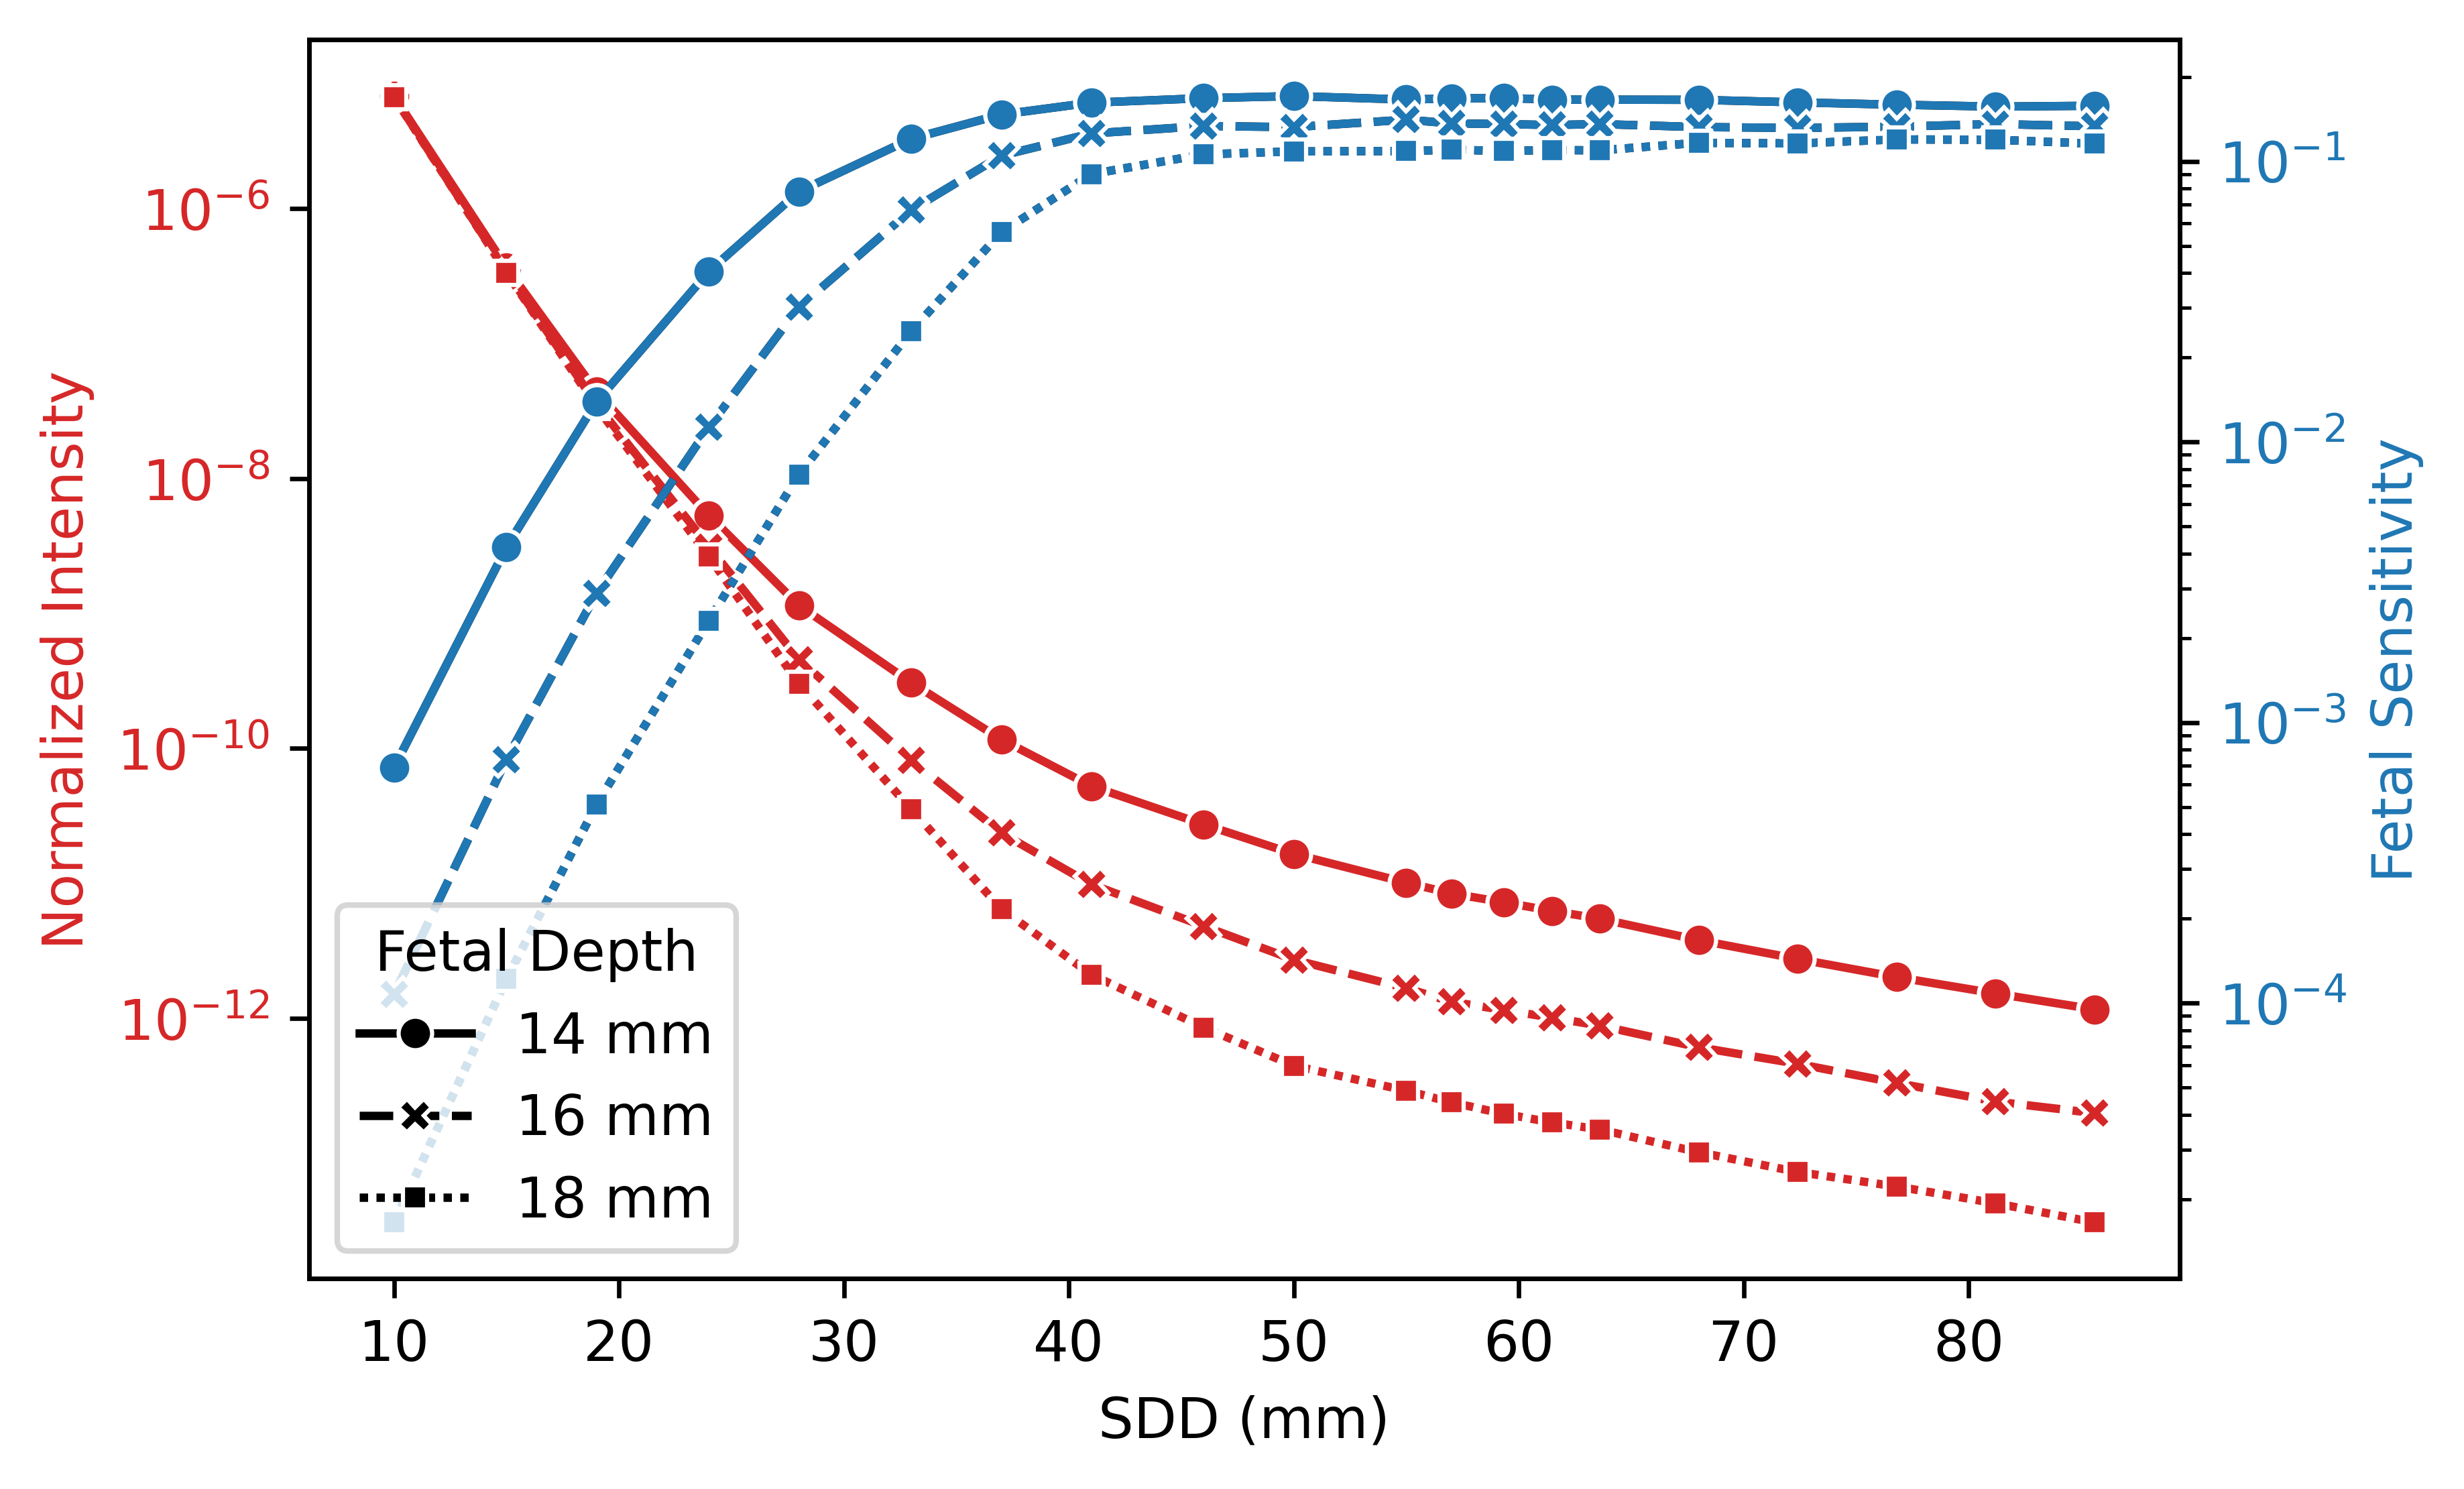

In [6]:
# Plot Sensitivity & Intensity on the same plot with two different y-axis
sensitivity_df_to_plot = sensitivity_df.copy()
# Write mm at the end of Fetal Depth for all the values
sensitivity_df_to_plot["Fetal Depth"] = sensitivity_df_to_plot["Fetal Depth"].astype(str) + " mm"

# Define the desired order of fetal depths
fetal_depth_order = sorted(sensitivity_df_to_plot["Fetal Depth"].unique(), key=lambda x: float(x.split()[0]))

fig, ax1 = plt.subplots(figsize=(6, 4), dpi=600)
color = "tab:red"
ax1.set_xlabel("SDD (mm)")
ax1.set_ylabel("Intensity", color=color)
sns.lineplot(
    data=sensitivity_df_to_plot,
    x="SDD",
    y="Intensity",
    style="Fetal Depth",
    style_order=fetal_depth_order,
    markers=True,
    ax=ax1,
    legend=False,
    color=color,
)
ax1.tick_params(axis="y", labelcolor=color)
ax1.set_ylabel("Normalized Intensity")
ax1.set_yscale("log")

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("Fetal Sensitivity", color=color)

sns.lineplot(
    data=sensitivity_df_to_plot,
    x="SDD",
    y="Sensitivity",
    style="Fetal Depth",
    style_order=fetal_depth_order,
    markers=True,
    ax=ax2,
    color="black",
)  # Just get the legend with a different color
legend = plt.legend(loc="lower left")
legend.set_title("Fetal Depth")

sns.lineplot(
    data=sensitivity_df_to_plot,
    x="SDD",
    y="Sensitivity",
    style="Fetal Depth",
    style_order=fetal_depth_order,
    markers=True,
    ax=ax2,
    color=color,
    legend=False,
)  # Actual Plot
ax2.tick_params(axis="y", labelcolor=color)
ax2.set_yscale("log")
plt.show()